In [30]:
from openvino.inference_engine import IENetwork, IEPlugin
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
aa = np.random.randn(100).reshape(1,-1)
bb = np.random.randn(100).reshape(1,-1)
cc = np.array([40,54,690]).reshape(1,-1)

cosine_similarity(aa, bb)[0][0]

0.031796868684713396

In [2]:
plugin = IEPlugin(device="CPU")
plugin.add_cpu_extension(r"C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\inference_engine\bin\intel64\Release\cpu_extension_avx2.dll")

model_xml = "models/person-detection-retail-0013.xml"
model_bin = "models/person-detection-retail-0013.bin"

In [3]:
def load_model(plugin, model, weights):
    """
    Load OpenVino IR Models

    Input:
    Plugin = Hardware Accelerator
    Model = model_xml file 
    Weights = model_bin file
    
    Output:
    execution network (exec_net)
    """
    #  Read in Graph file (IR) to create network
    net = IENetwork(model, weights) 
    # Load the Network using Plugin Device
    exec_net = plugin.load(network=net)
    return net, exec_net

def preprocessing(n, c, h, w, image):
    """
    Image Preprocessing steps, to match image 
    with Input Neural nets
    
    N=1, Channel=3, Height=62, Width=62
    """
    blob = cv.resize(image, (w, h)) # Resize width & height
    blob = blob.transpose((2, 0, 1)) # Change data layout from HWC to CHW
    blob = blob.reshape((n, c, h, w))
    return blob

## Person Detection

In [4]:
net, exec_net = load_model(plugin, model_xml,model_bin)

input_net = 'data'
output_net = 'detection_out'

n,c,h,w = net.inputs[input_net].shape

In [5]:
net.outputs['detection_out'].shape

[1, 1, 200, 7]

(902, 1601, 3)


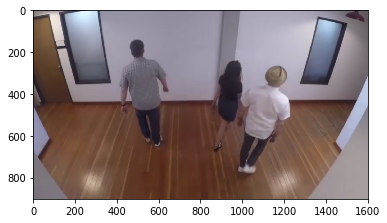

In [6]:
image = cv.imread('test_image1.png')
plt.imshow(image[...,::-1]);
print(image.shape)

In [7]:
blob = preprocessing(n,c,h,w, image)
req_handle = exec_net.start_async(0, {input_net:blob})

In [8]:
status = req_handle.wait()
res = req_handle.outputs[output_net]
res.shape

(1, 1, 200, 7)

In [9]:
res[0][0][0:3]

array([[0.        , 1.        , 0.998926  , 0.59963655, 0.3004798 ,
        0.7743883 , 0.9180858 ],
       [0.        , 1.        , 0.99802905, 0.25844464, 0.1570496 ,
        0.40431592, 0.94416374],
       [0.        , 1.        , 0.99061686, 0.53394294, 0.2651455 ,
        0.63580334, 0.8010309 ]], dtype=float32)

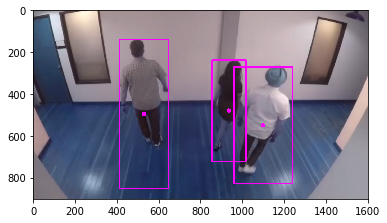

In [18]:
person_db = []
for detection in res[0][0]:
    confidence = detection[2]
    xmin = int(detection[3] * image.shape[1])
    ymin = int(detection[4] * image.shape[0])
    xmax = int(detection[5] * image.shape[1])
    ymax = int(detection[6] * image.shape[0])
    if confidence > 0.9:
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,255), 5)
        crop_person = image[ymin:ymax, xmin:xmax]
        person_db.append(crop_person)
        centroid = (int(xmin + ((xmax - xmin)/2)), int(ymin + ((ymax-ymin)/2)))
        cv.circle(image, centroid, 5, (255,0,255), 10)
        

plt.imshow(image);

In [22]:
for i in person_db:
    print(i.shape)

(557, 279, 3)
(710, 234, 3)
(483, 163, 3)


In [17]:
crop_person[2].shape

(163, 3)

## Reidentification

In [12]:
reid_xml = "models/person-reidentification-retail-0031.xml"
reid_bin = "models/person-reidentification-retail-0031.bin"

reid_net, reid_exec_net = load_model(plugin, reid_xml, reid_bin)

In [13]:
input_net = 'data'
output_net = 'ip_reid'

n,c,h,w = reid_net.inputs[input_net].shape
print(n, c, h, w)

1 3 96 48


In [23]:
blob = preprocessing(n,c,h,w, person_db[0])
req_handle = reid_exec_net.start_async(0, {input_net:blob})

In [24]:
status = req_handle.wait()
res = req_handle.outputs[output_net]

In [28]:
res[0]

array([ 1.90681589e+00,  2.75495887e+00,  1.48295864e-01,  6.79951251e-01,
       -3.64220214e+00,  2.02502584e+00,  2.07404804e+00,  4.81007957e+00,
        4.24983501e+00,  1.14145815e-01,  1.98211813e+00,  3.38007903e+00,
        1.06391001e+00, -4.44248855e-01, -3.65815520e+00,  2.54662704e+00,
       -6.34093821e-01, -2.38831806e+00, -3.88696051e+00, -3.76349211e-01,
       -2.36878347e+00, -2.21964431e+00,  1.64571249e+00, -1.60908140e-02,
        3.58846784e-03, -3.31868267e+00, -1.37919247e+00,  1.93425930e+00,
       -2.37513375e+00,  4.08453703e-01, -4.53911364e-01,  2.29184604e+00,
        3.54211926e-01,  1.68643570e+00,  1.31112897e+00,  2.52550316e+00,
        2.33413744e+00, -8.04778695e-01,  1.49210835e+00,  1.28954995e+00,
       -3.09116316e+00,  1.93080258e+00,  3.44374514e+00,  4.50531006e-01,
        2.02029198e-02, -5.59569569e-03, -2.32013607e+00, -2.43882346e+00,
       -7.97417641e-01, -1.43695390e+00,  2.08504796e+00,  3.32682896e+00,
       -1.70065320e+00,  